# Optimizing shipment for a network of production and distribution nodes

### Production facilities
These facilities are equipped with a maximum quantity they can produce.
There is also a minimum production criteria of <b>75%</b>

### Distribution facilities
These facilities raise demands that need to be fulfilled by production facilities

### Transportation cost
There is a transportation cost per unit quantity of goods roughly based on the Euclidian distance from one location to the other

## Expansion
Based on the final cost incurred, we will look into expansion strategies and take decisions on the best production facility to expand its capacity of maximum production

In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
import random

In [2]:
data_path = "data/"
cost_file1 = data_path+"cost.csv"
cost_file2 = data_path+"costs_new.csv"
cost_dist_based_file = data_path+"costs_dist_based.csv"
demand_file1 = data_path+"demand.csv"
demand_file2 = data_path+"demand_new.csv"
expansion_file1 = data_path+"expansion.csv"
expansion_file2 = data_path+"expansion_new.csv"
max_prod_file1 = data_path+"max_prod.csv"
max_prod_file2 = data_path+"max_prod_new.csv"

In [3]:
trans_cost = pd.read_csv(cost_file2).set_index(['production','distribution']).squeeze("columns")
demand = pd.read_csv(demand_file2, names = ['location', 'demand'], index_col=0).squeeze().to_dict()
max_prod = pd.read_csv(max_prod_file2, names = ['location', 'prod_max'], index_col=0).squeeze().to_dict()
distribution = []
for loc in demand:
    distribution.append(loc)
production = []
for loc in max_prod:
    production.append(loc)
expansion = pd.read_csv(expansion_file2, index_col=0).to_dict(orient="index")
min_util = 0.75

In [4]:
m = gp.Model('original')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-28


In [5]:
x = m.addVars(
    production, distribution,
    lb = 0,
    vtype=GRB.INTEGER,
    name = "transp"
)

In [6]:
dem_con = m.addConstrs(
    (gp.quicksum(
        x[p,d]
        for p in production
        ) >= demand[d]
        for d in distribution),
        name = "demand"
)
can_prod = m.addConstrs(
    (
        gp.quicksum(
            x[p,d]
            for d in distribution
        ) <= max_prod[p]
        for p in production
    ), name="max_production"
)
must_prod = m.addConstrs(
    (
        gp.quicksum(
            x[p,d]
            for d in distribution
        ) >= max_prod[p] * min_util
        for p in production
    ), name="min_production"
)

In [7]:
m.setObjective(
    gp.quicksum(
        x[p,d]*trans_cost[p,d]
        for p in production
        for d in distribution
    )
)

In [8]:
m.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 32 rows, 128 columns and 384 nonzeros
Model fingerprint: 0x84f05fb4
Variable types: 0 continuous, 128 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 4e+02]
Found heuristic solution: objective 7838.2700000
Presolve time: 0.00s
Presolved: 32 rows, 128 columns, 384 nonzeros
Variable types: 0 continuous, 128 integer (0 binary)
Found heuristic solution: objective 7806.1400000

Root relaxation: objective 4.449650e+03, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    4449.6500000 4449.

# Post-optimality Analysis

In [9]:
obj1 = m.getObjective().getValue()
print("Obj1 : ",round(obj1,2))

Obj1 :  4449.65


In [10]:
x_vals = pd.Series(m.getAttr('X',x), name='shipment', index=trans_cost.index)
sol = pd.concat([trans_cost, x_vals], axis=1)
sol['shipment'] = sol['shipment'].astype(int)
sol['total_cost'] = sol['cost'] * sol['shipment']
pos_sol = sol[sol['shipment']>0]
pos_sol

cost  shipment  total_cost
production  distribution                            
Atlanta     Columbia      2.94        67      196.98
            Houston       1.56       143      223.08
            Nashville     2.61        24       62.64
            San Diego     2.80       101      282.80
Baltimore   Austin        1.79       150      268.50
            Charlotte     2.89       124      358.36
            Richmond      1.96        26       50.96
Birmingham  Nashville     1.53       100      153.00
Charleston  Boston        2.80        45      126.00
            Indianapolis  2.61        93      242.73
            Lexington     1.61       109      175.49
            Richmond      2.36       103      243.08
Cleveland   Boston        2.45        63      154.35
            Columbia      2.43        30       72.90
            Minneapolis   2.48        87      215.76
Dallas      Seattle       1.61       141      227.01
            St. Louis     2.52       189      476.28
Denver      Indianapolis  2.82        10       28.20
            Miami         2.24       161      360.64
            Portland      1.40       135      189.00
            Seattle       2.68         2        5.36
Little Rock Charlotte     1.78        17       30.26
            Phoenix       2.49       123      306.27

In [11]:
sol

cost  shipment  total_cost
production  distribution                            
Atlanta     Austin        3.97         0        0.00
            Boston        3.74         0        0.00
            Charlotte     5.03         0        0.00
            Columbia      2.94        67      196.98
            Houston       1.56       143      223.08
...                        ...       ...         ...
Little Rock Portland      4.02         0        0.00
            Richmond      7.44         0        0.00
            San Diego     2.76         0        0.00
            Seattle       1.38         0        0.00
            St. Louis     2.92         0        0.00

[128 rows x 3 columns]

In [12]:
total_outgoing = sol.groupby(['production'])['shipment'].sum()
total_outgoing.to_frame()

,shipment
production,
Atlanta,335
Baltimore,300
Birmingham,100
Charleston,350
Cleveland,180
Dallas,330
Denver,308
Little Rock,140


In [13]:
total_outgoing_cost = sol.groupby(['production'])['total_cost'].sum()
total_outgoing_cost.to_frame()

,total_cost
production,
Atlanta,765.50
Baltimore,677.82
Birmingham,153.00
Charleston,787.30
Cleveland,443.01
Dallas,703.29
Denver,583.20
Little Rock,336.53


In [14]:
Slack_check = pd.DataFrame(
    {"Remaining":[can_prod[p].Slack for p in production],
     "Utilization %": [round((1 - can_prod[p].Slack/max_prod[p])*100,2) for p in production] }, index= production
)
Slack_check['Remaining']=Slack_check['Remaining'].astype(int)
Slack_check

,Remaining,Utilization %
Baltimore,0,100.00
Cleveland,0,100.00
Little Rock,0,100.00
Birmingham,0,100.00
Charleston,0,100.00
Atlanta,35,90.54
Dallas,0,100.00
Denver,102,75.12


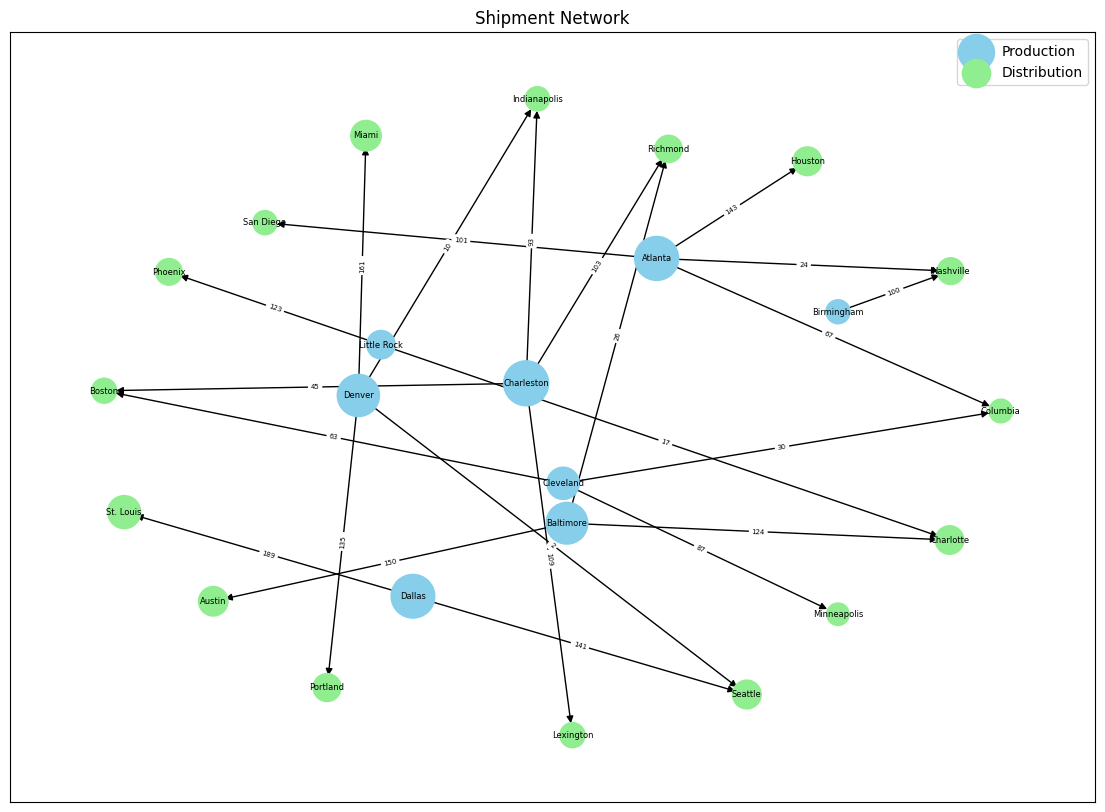

In [15]:
G = nx.DiGraph()

# Add nodes for production and distribution locations
for loc in production:
    G.add_node(loc, type='production')
for loc in distribution:
    G.add_node(loc, type='distribution')

# Add edges with shipment quantities
for _, row in pos_sol.iterrows():
    G.add_edge(row.name[0], row.name[1], weight=int(row['shipment']), cost=row['total_cost'])

# Define positions for the nodes
pos = nx.spring_layout(G)
plt.figure(figsize=(14, 10))

node_sizes = {}
for node in G.nodes:
    total_weight = sum(d['weight'] for _, _, d in G.in_edges(node, data=True)) + sum(d['weight'] for _, _, d in G.out_edges(node, data=True))
    node_sizes[node] = total_weight * 3  # Scale the size as needed

# Draw the nodes
nx.draw_networkx_nodes(G, pos, nodelist=production, node_color='skyblue', node_size=[node_sizes[n] for n in production], label='Production')
nx.draw_networkx_nodes(G, pos, nodelist=distribution, node_color='lightgreen', node_size=[node_sizes[n] for n in distribution], label='Distribution')

# Draw the edges
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='-|>', arrowsize=10)

# Draw the edge labels (shipment quantities)
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5)

# Draw the node labels
nx.draw_networkx_labels(G, pos, font_size=6, font_family="sans-serif")

plt.title("Shipment Network")
plt.legend(["Production", "Distribution"])
plt.show()

In [16]:
locations = pd.read_csv(data_path+'locations.csv', index_col='place')

/var/folders/kj/vrxl3nq50bd1kwzl4qm84pzr0000gn/T/ipykernel_69999/1594089454.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


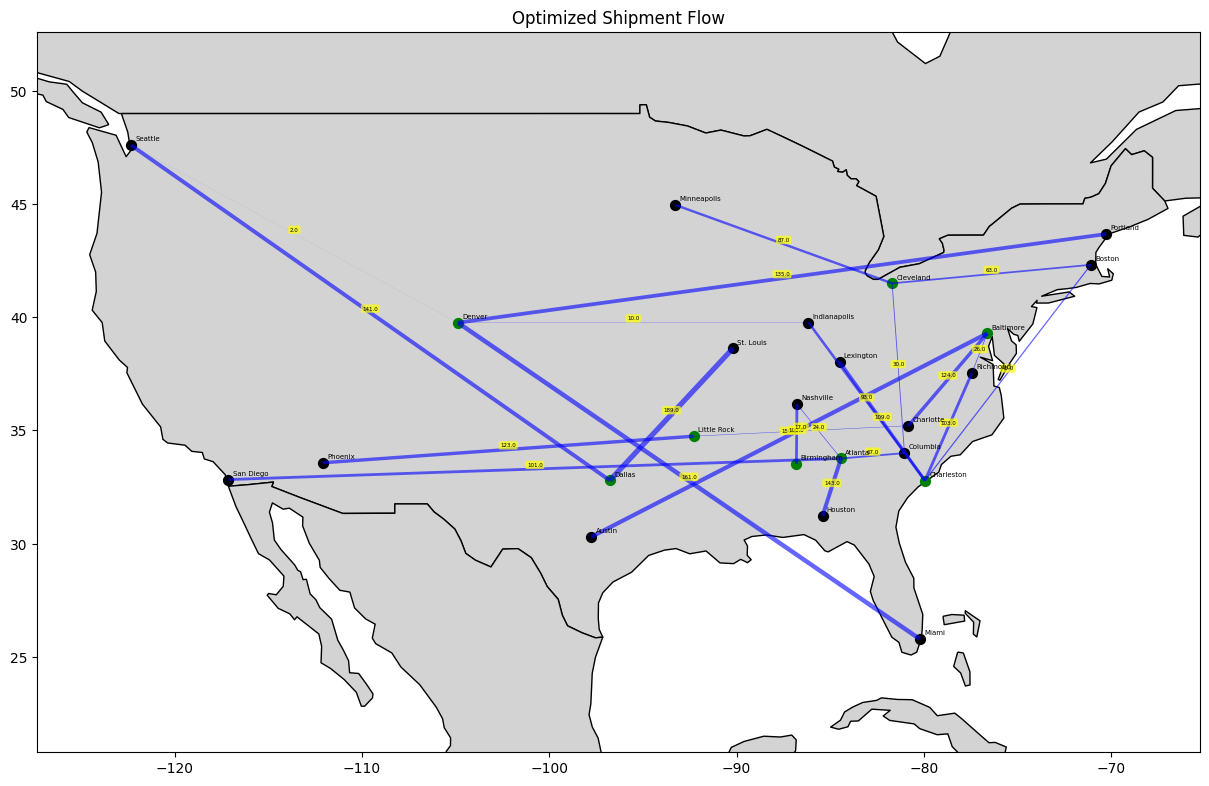

In [17]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    locations, 
    geometry=[Point(xy) for xy in zip(locations.longitude, locations.latitude)],
    crs="EPSG:4326"
)

# Create a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the locations
# gdf.plot(ax=ax, color='red', markersize=50)

gdf.loc[production].plot(ax=ax, color='green', markersize=50)
gdf.loc[distribution].plot(ax=ax, color='black', markersize=50)

# Add shipment lines and labels
for (p, d), row in sol.iterrows():
    if row['shipment'] > 0:
        start = gdf.loc[p, 'geometry']
        end = gdf.loc[d, 'geometry']
        line = LineString([start, end])
        line_gdf = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")
        line_gdf.plot(ax=ax, linewidth=row['shipment']/50, color='blue', alpha=0.6)
        
        # Calculate midpoint for label placement
        midpoint = [(start.x + end.x) / 2, (start.y + end.y) / 2]
        
        # Add label with shipment amount
        ax.annotate(f"{row['shipment']:.1f}", 
                    xy=midpoint, 
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', 
                    va='center',
                    bbox=dict(boxstyle='round,pad=0.3', fc='yellow', ec='none', alpha=0.7),
                    fontsize=4)

# Add labels for the locations
for idx, row in gdf.iterrows():
    ax.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(3, 3), 
                textcoords="offset points", fontsize=5)

# Set the map extent to focus on the relevant area
ax.set_xlim(gdf.total_bounds[0]-5, gdf.total_bounds[2]+5)
ax.set_ylim(gdf.total_bounds[1]-5, gdf.total_bounds[3]+5)

plt.title('Optimized Shipment Flow')
plt.show()

# Expansion

In [18]:
def optimize_shipment(min_loc):
    m3 = gp.Model('expansion_func')
    x_new = m3.addVars(
        production, distribution,
        lb = 0,
        vtype=GRB.INTEGER,
        name = "new_transp"
    )
    exp = m3.addVars(
        expansion,
        vtype=GRB.BINARY,
        name ="new_exp"
    )
    dem_con_new = m3.addConstrs(
        (gp.quicksum(
            x_new[p,d]
            for p in production
            ) >= demand[d]
            for d in distribution),
            name = "demand"
    )
    can_prod_new = m3.addConstrs(
        (
            gp.quicksum(
                x_new[p,d]
                for d in distribution
            ) <= max_prod[p]
            for p in production if p!= min_loc
        ), name="max_production_new"
    )
    must_prod_new = m3.addConstrs(
        (
            gp.quicksum(
                x_new[p,d]
                for d in distribution
            ) >= max_prod[p] * min_util
            for p in production if p!= min_loc
        ), name="min_production_new"
    )
    exp_max_con = m3.addConstr(
        gp.quicksum(
            x_new[min_loc,d]
            for d in distribution
        ) <= max_prod[min_loc] +
        gp.quicksum(
            exp[e]*expansion[e]['qty']
            for e in list(expansion.keys())
        ), name="exp_max_prod"
    )
    exp_min_con = m3.addConstr(
        gp.quicksum(
            x_new[min_loc,d]
            for d in distribution
        ) >= max_prod[min_loc] +
        min_util * gp.quicksum(
            exp[e]*expansion[e]['qty']
            for e in list(expansion.keys())
        ), name="exp_min_prod"
    )
    exp_bal_con = m3.addConstr(
        gp.quicksum(
            exp[e] for e in list(expansion.keys())
        ) <= 1, name="exp_balance"
    )
    m3.setObjective(
        gp.quicksum(
            x_new[p,d]*trans_cost[p,d]
            for p in production
            for d in distribution
        )+
        gp.quicksum(
            exp[e]*expansion[e]['cost']
            for e in list(expansion.keys())
        )
    )
    m3.optimize()
    obj2 = m3.getObjective().getValue()
    x_new_vals = pd.Series(m3.getAttr('X',x_new), name=min_loc+' expqty', index=trans_cost.index).astype(int)
    exp_vals = pd.Series(m3.getAttr('X',exp), name=min_loc+'exp',index=list(expansion.keys()))
    can_prod_slack = pd.Series([round((1-(can_prod_new[p].Slack/max_prod[p]))*100,2) for p in list(can_prod_new.keys())], name=min_loc+' exp_util', index = list(can_prod_new.keys()))
    can_prod_minloc_slack = pd.Series({min_loc: round((1-(exp_max_con.Slack/max_prod[min_loc]))*100,2)})
    can_prod_slack_all = pd.concat([can_prod_slack,can_prod_minloc_slack], axis=0).to_frame(min_loc+' exp_util')
    return obj2, x_new_vals, exp_vals, can_prod_slack_all

In [19]:
obj_list = {}
sol_new = pd.DataFrame()
exp_all = pd.DataFrame(index=list(expansion.keys()))
utilization = pd.DataFrame(index=production)
for loc in production:
    obj_new, x_new_res, exp_vals, can_prod_slack = optimize_shipment(loc)
    obj_list[loc] = obj_new
    sol_new = pd.concat([sol_new, pd.concat([trans_cost, x_new_res], axis=1)], axis=1)
    exp_all[loc]=exp_vals
    utilization = pd.concat([utilization, can_prod_slack], axis=1)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 33 rows, 136 columns and 408 nonzeros
Model fingerprint: 0x535396ee
Variable types: 0 continuous, 136 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 8882.7500000
Presolve time: 0.00s
Presolved: 33 rows, 136 columns, 408 nonzeros
Variable types: 0 continuous, 136 integer (8 binary)
Found heuristic solution: objective 8850.2100000

Root relaxation: objective 4.437395e+03, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4437.39522    0    1 8850.21000 4437.

In [20]:
utilization = utilization.reindex(sorted(utilization.columns), axis=1)
utilization.sort_index(inplace=True)
utilization


,Atlanta exp_util,Baltimore exp_util,Birmingham exp_util,Charleston exp_util,Cleveland exp_util,Dallas exp_util,Denver exp_util,Little Rock exp_util
Atlanta,100.00,77.03,75.14,90.54,77.03,77.03,75.14,75.14
Baltimore,100.00,100.00,100.00,100.00,100.00,100.00,100.00,98.00
Birmingham,100.00,100.00,87.00,100.00,100.00,100.00,100.00,100.00
Charleston,90.00,100.00,91.43,100.00,100.00,100.00,87.14,75.14
Cleveland,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Dallas,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Denver,75.12,75.12,75.12,75.12,75.12,75.12,100.00,75.12
Little Rock,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [21]:
exp_all = exp_all.transpose().astype(int)
exp_all.index.name = 'Location'
obj_list_df = pd.DataFrame(list(obj_list.items()), columns=['Location','Objective']).set_index('Location')
final_expansion = pd.concat([obj_list_df,exp_all],axis=1)
final_expansion['Expansion'] = final_expansion.apply(lambda row: ', '.join([col for col in final_expansion.columns[1:] if row[col] == 1]), axis=1)
final_expansion['Expansion'] = final_expansion['Expansion'].replace('', 'No_exp')

In [22]:
sol_new = sol_new.loc[:, ~sol_new.columns.duplicated()]
pos_sol_new = sol_new[sol_new.iloc[:,1:].sum(axis=1)>0]
pos_sol_new

cost  Baltimore expqty  Cleveland expqty  \
production  distribution                                             
Atlanta     Boston        3.74                 0                 0   
            Columbia      2.94                17                17   
            Houston       1.56               143               143   
            Nashville     2.61                24                24   
            San Diego     2.80               101               101   
Baltimore   Austin        1.79               150               150   
            Boston        2.71                 0                 0   
            Charlotte     2.89               124               124   
            Richmond      1.96                76                26   
Birmingham  Nashville     1.53               100               100   
            San Diego     1.98                 0                 0   
Charleston  Boston        2.80                95                45   
            Indianapolis  2.61                93                93   
            Lexington     1.61               109               109   
            Richmond      2.36                53               103   
Cleveland   Boston        2.45                13                63   
            Columbia      2.43                80                80   
            Minneapolis   2.48                87                87   
Dallas      San Diego     2.34                 0                 0   
            Seattle       1.61               141               141   
            St. Louis     2.52               189               189   
Denver      Columbia      3.09                 0                 0   
            Indianapolis  2.82                10                10   
            Miami         2.24               161               161   
            Portland      1.40               135               135   
            Seattle       2.68                 2                 2   
Little Rock Charlotte     1.78                17                17   
            Phoenix       2.49               123               123   
            Seattle       1.38                 0                 0   

                          Little Rock expqty  Birmingham expqty  \
production  distribution                                          
Atlanta     Boston                         0                  0   
            Columbia                      34                 97   
            Houston                      143                143   
            Nashville                     24                  0   
            San Diego                     77                 38   
Baltimore   Austin                       150                150   
            Boston                        15                  0   
            Charlotte                      0                124   
            Richmond                     129                 26   
Birmingham  Nashville                    100                124   
            San Diego                      0                 63   
Charleston  Boston                        63                 15   
            Indianapolis                  91                 93   
            Lexington                    109                109   
            Richmond                       0                103   
Cleveland   Boston                        30                 93   
            Columbia                      63                  0   
            Minneapolis                   87                 87   
Dallas      San Diego                     24                  0   
            Seattle                      117                141   
            St. Louis                    189                189   
Denver      Columbia                       0                  0   
            Indianapolis                  12                 10   
            Miami                        161                161   
            Portland                     135                135   
            Seattle                        0  

In [23]:
pos_sol_new_grp = pos_sol_new.groupby(['production']).sum().drop('cost',axis=1)
pos_sol_new_grp.index.name='Location'

pos_sol_new_grp = pos_sol_new_grp.reindex(sorted(pos_sol_new_grp.columns), axis=1)
pos_sol_new_grp

,Atlanta expqty,Baltimore expqty,Birmingham expqty,Charleston expqty,Cleveland expqty,Dallas expqty,Denver expqty,Little Rock expqty
Location,,,,,,,,
Atlanta,370,285,278,335,285,285,278,278
Baltimore,300,350,300,300,300,300,300,294
Birmingham,100,100,187,100,100,100,100,100
Charleston,315,350,320,350,350,350,305,263
Cleveland,180,180,180,180,230,180,180,180
Dallas,330,330,330,330,330,380,330,330
Denver,308,308,308,308,308,308,410,308
Little Rock,140,140,140,140,140,140,140,290


In [24]:
expansion_details = final_expansion[['Objective','Expansion']].merge(pos_sol_new_grp, left_index=True, right_index=True).sort_index()
expansion_details

,Objective,Expansion,Atlanta expqty,Baltimore expqty,Birmingham expqty,Charleston expqty,Cleveland expqty,Dallas expqty,Denver expqty,Little Rock expqty
Location,,,,,,,,,,
Atlanta,4459.15,No_exp,370,285,278,335,285,285,278,278
Baltimore,4441.65,exp1,300,350,300,300,300,300,300,294
Birmingham,4421.87,exp2,100,100,187,100,100,100,100,100
Charleston,4449.65,No_exp,315,350,320,350,350,350,305,263
Cleveland,4444.15,exp1,180,180,180,180,230,180,180,180
Dallas,4445.53,exp1,330,330,330,330,330,380,330,330
Denver,4462.85,No_exp,308,308,308,308,308,308,410,308
Little Rock,4305.44,exp3,140,140,140,140,140,140,140,290


In [25]:
pos_sol_new

cost  Baltimore expqty  Cleveland expqty  \
production  distribution                                             
Atlanta     Boston        3.74                 0                 0   
            Columbia      2.94                17                17   
            Houston       1.56               143               143   
            Nashville     2.61                24                24   
            San Diego     2.80               101               101   
Baltimore   Austin        1.79               150               150   
            Boston        2.71                 0                 0   
            Charlotte     2.89               124               124   
            Richmond      1.96                76                26   
Birmingham  Nashville     1.53               100               100   
            San Diego     1.98                 0                 0   
Charleston  Boston        2.80                95                45   
            Indianapolis  2.61                93                93   
            Lexington     1.61               109               109   
            Richmond      2.36                53               103   
Cleveland   Boston        2.45                13                63   
            Columbia      2.43                80                80   
            Minneapolis   2.48                87                87   
Dallas      San Diego     2.34                 0                 0   
            Seattle       1.61               141               141   
            St. Louis     2.52               189               189   
Denver      Columbia      3.09                 0                 0   
            Indianapolis  2.82                10                10   
            Miami         2.24               161               161   
            Portland      1.40               135               135   
            Seattle       2.68                 2                 2   
Little Rock Charlotte     1.78                17                17   
            Phoenix       2.49               123               123   
            Seattle       1.38                 0                 0   

                          Little Rock expqty  Birmingham expqty  \
production  distribution                                          
Atlanta     Boston                         0                  0   
            Columbia                      34                 97   
            Houston                      143                143   
            Nashville                     24                  0   
            San Diego                     77                 38   
Baltimore   Austin                       150                150   
            Boston                        15                  0   
            Charlotte                      0                124   
            Richmond                     129                 26   
Birmingham  Nashville                    100                124   
            San Diego                      0                 63   
Charleston  Boston                        63                 15   
            Indianapolis                  91                 93   
            Lexington                    109                109   
            Richmond                       0                103   
Cleveland   Boston                        30                 93   
            Columbia                      63                  0   
            Minneapolis                   87                 87   
Dallas      San Diego                     24                  0   
            Seattle                      117                141   
            St. Louis                    189                189   
Denver      Columbia                       0                  0   
            Indianapolis                  12                 10   
            Miami                        161                161   
            Portland                     135                135   
            Seattle                        0  

In [29]:
best_yield = {}
best_yield['loc'] = expansion_details['Objective'].idxmin()
best_yield['strat'] = expansion_details.loc[expansion_details['Objective'].idxmin(), 'Expansion']

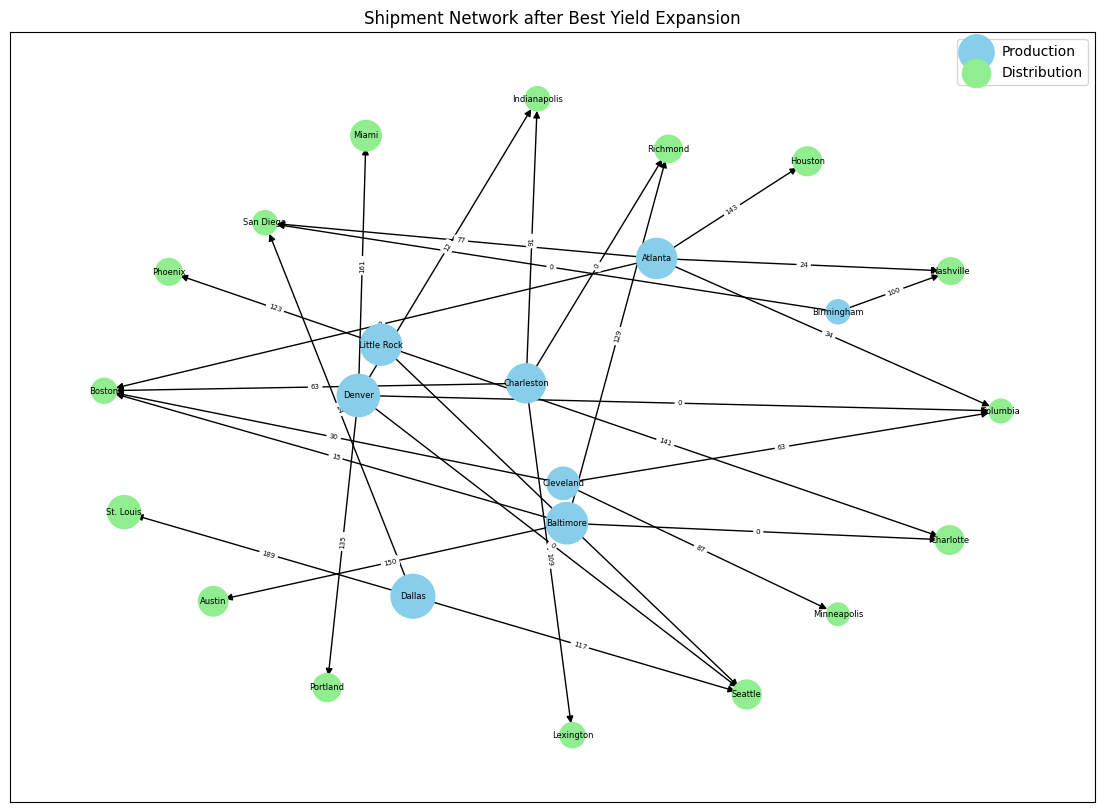

In [27]:
G1 = nx.DiGraph()

# Add nodes for production and distribution locations
for loc in production:
    G1.add_node(loc, type='production')
for loc in distribution:
    G1.add_node(loc, type='distribution')

for _, row in pos_sol_new.iterrows():
    G1.add_edge(row.name[0], row.name[1], weight=int(row[best_yield['loc']+' expqty']))
    
# Define positions for the nodes
plt.figure(figsize=(14, 10))

node_sizes = {}
for node in G1.nodes:
    total_weight = sum(d['weight'] for _, _, d in G1.in_edges(node, data=True)) + sum(d['weight'] for _, _, d in G1.out_edges(node, data=True))
    node_sizes[node] = total_weight * 3  # Scale the size as needed

# Draw the nodes
nx.draw_networkx_nodes(G1, pos, nodelist=production, node_color='skyblue', node_size=[node_sizes[n] for n in production], label='Production')
nx.draw_networkx_nodes(G1, pos, nodelist=distribution, node_color='lightgreen', node_size=[node_sizes[n] for n in distribution], label='Distribution')

# Draw the edges
edges = G1.edges(data=True)
nx.draw_networkx_edges(G1, pos, edgelist=edges, arrowstyle='-|>', arrowsize=10)

# Draw the edge labels (shipment quantities)
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels, font_size=5)

# Draw the node labels
nx.draw_networkx_labels(G1, pos, font_size=6, font_family="sans-serif")

plt.title("Shipment Network after Best Yield Expansion")
plt.legend(["Production", "Distribution"])
plt.show()

/var/folders/kj/vrxl3nq50bd1kwzl4qm84pzr0000gn/T/ipykernel_69999/1249169037.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


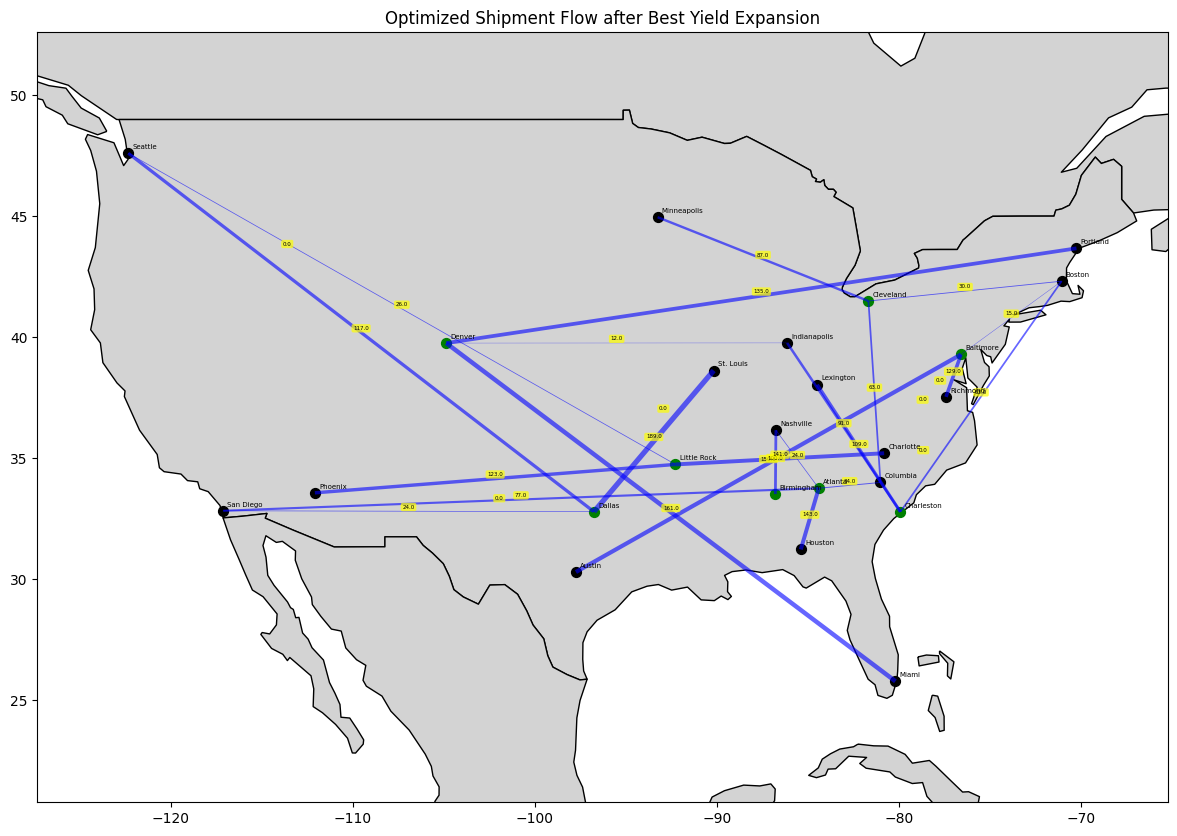

In [28]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    locations, 
    geometry=[Point(xy) for xy in zip(locations.longitude, locations.latitude)],
    crs="EPSG:4326"
)

# Create a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the locations
# gdf.plot(ax=ax, color='red', markersize=50)

gdf.loc[production].plot(ax=ax, color='green', markersize=50)
gdf.loc[distribution].plot(ax=ax, color='black', markersize=50)

# Add shipment lines and labels
for (p, d), row in pos_sol_new.iterrows():
    start = gdf.loc[p, 'geometry']
    end = gdf.loc[d, 'geometry']
    line = LineString([start, end])
    line_gdf = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")
    line_gdf.plot(ax=ax, linewidth=row[best_yield['loc']+' expqty']/50, color='blue', alpha=0.6)
    
    # Calculate midpoint for label placement
    midpoint = [(start.x + end.x) / 2, (start.y + end.y) / 2]
    
    # Add label with shipment amount
    ax.annotate(f"{row[best_yield['loc']+' expqty']:.1f}", 
                xy=midpoint, 
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', 
                va='center',
                bbox=dict(boxstyle='round,pad=0.3', fc='yellow', ec='none', alpha=0.7),
                fontsize=4)

# Add labels for the locations
for idx, row in gdf.iterrows():
    ax.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(3, 3), 
                textcoords="offset points", fontsize=5)

# Set the map extent to focus on the relevant area
ax.set_xlim(gdf.total_bounds[0]-5, gdf.total_bounds[2]+5)
ax.set_ylim(gdf.total_bounds[1]-5, gdf.total_bounds[3]+5)

plt.title('Optimized Shipment Flow after Best Yield Expansion')
plt.show()